<center><h1>Papcorns Case</h1></center>

# 1.Imports

In [1356]:
!pip install -r requirements.txt

In [1176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import os

from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso,Ridge
from sklearn.metrics import classification_report,mean_absolute_error,accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from xgboost import XGBRegressor,XGBClassifier

In [1178]:
sns.set_style('darkgrid') # to change the style of visuals
os.makedirs('Visuals', exist_ok=True) # create a directory if not already exists to store graphs.

# 2.Sql to Python

## 2.1. Connection

In [1182]:
conn = sqlite3.connect('papcorns.sqlite')

## 2.2. Creating Pandas DataFrames

In [1185]:
users_df = pd.read_sql_query("SELECT * FROM users;", conn)
users_df = users_df.rename(columns={col:f"user_{col}" for col in users_df.columns})

events_df = pd.read_sql_query("SELECT * FROM user_events;", conn)

# 3.First look at DataFrames

## 3.1. users Dataframe

In [1189]:
users_df.sample(3)

,user_id,user_created_at,user_attribution_source,user_country,user_name
734,735,2024-05-27T00:00:00,instagram,TR,Grace Wilson
635,636,2024-07-22T00:00:00,tiktok,TR,Frank Davis
803,804,2024-06-01T00:00:00,tiktok,NL,Grace Williams


In [1191]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   user_id                  1002 non-null   int64 
 1   user_created_at          1002 non-null   object
 2   user_attribution_source  1002 non-null   object
 3   user_country             1002 non-null   object
 4   user_name                1002 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.3+ KB


In [1193]:
users_df.describe(include='object')

,user_created_at,user_attribution_source,user_country,user_name
count,1002,1002,1002,1002
unique,384,3,3,102
top,2024-07-01T00:00:00,tiktok,TR,Henry Jones
freq,8,352,354,18


In [1195]:
users_df.isnull().sum()

user_id                    0
user_created_at            0
user_attribution_source    0
user_country               0
user_name                  0
dtype: int64

## 3.2.events Dataframe

In [1198]:
events_df.sample(3)

,id,created_at,user_id,event_name,amount_usd
633,634,2024-12-26T00:00:00,191,subscription_renewed,4.99
2495,2496,2024-06-16T00:00:00,716,trial_cancelled,NaN
3051,3052,2024-06-02T00:00:00,881,subscription_started,4.99


In [1200]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          3486 non-null   int64  
 1   created_at  3486 non-null   object 
 2   user_id     3486 non-null   int64  
 3   event_name  3486 non-null   object 
 4   amount_usd  1231 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 136.3+ KB


In [1202]:
events_df.describe(include='all')

,id,created_at,user_id,event_name,amount_usd
count,3486.000000,3486,3486.000000,3486,1231.000000
unique,NaN,515,NaN,6,NaN
top,NaN,2025-02-15T00:00:00,NaN,app_install,NaN
freq,NaN,17,NaN,1002,NaN
mean,1743.500000,NaN,502.910499,NaN,7.836466
std,1006.465846,NaN,289.650625,NaN,2.220009
min,1.000000,NaN,1.000000,NaN,4.990000
25%,872.250000,NaN,256.250000,NaN,4.990000
50%,1743.500000,NaN,499.500000,NaN,8.990000
75%,2614.750000,NaN,754.000000,NaN,9.990000


This code calculates the percentage of null values in each column. It starts by dividing the number of nulls by the total number of rows in the dataset, which gives a value between 0 and 1. To make the result easier to understand, it multiplies this value by 100 to show the percentage. Finally, it converts the result into a DataFrame and adds a column name  "Null %" to clearly show what values represent.

In [1205]:
pd.DataFrame(events_df.isnull().sum() / len(events_df) * 100, columns=['Null %'])

,Null %
id,0.000000
created_at,0.000000
user_id,0.000000
event_name,0.000000
amount_usd,64.687321


Since the null values are only in the **amount_usd** column, I thought the reason might be the type of the event, not a real missing value. To make sure, I checked the number of null values for each event type by grouping them with **event_name**.

In [1208]:
events_df.groupby('event_name')['amount_usd'].apply(lambda x: x.isnull().sum())

event_name
app_install               1002
subscription_cancelled     370
subscription_renewed         0
subscription_started         0
trial_cancelled            201
trial_started              682
Name: amount_usd, dtype: int64

# 4.Merging both Dataframes

In [1211]:
merged_df = events_df.merge(users_df, on='user_id')

In [1213]:
merged_df.sample(5)

,id,created_at,user_id,event_name,amount_usd,user_created_at,user_attribution_source,user_country,user_name
1474,1475,2024-09-29T00:00:00,428,trial_started,NaN,2024-09-25T00:00:00,instagram,NL,Henry Williams
2701,2702,2024-02-15T00:00:00,781,subscription_started,9.99,2024-02-01T00:00:00,organic,US,Henry Williams
2300,2301,2024-06-16T00:00:00,661,subscription_renewed,8.99,2024-04-11T00:00:00,organic,NL,Frank Moore
1078,1079,2024-05-25T00:00:00,309,app_install,NaN,2024-05-25T00:00:00,instagram,US,Charlie Smith
2399,2400,2024-07-12T00:00:00,692,app_install,NaN,2024-07-12T00:00:00,tiktok,TR,Henry Taylor


# 5. Core Tasks

## 5.1. Revenue from Each Country

I solved with 2 ways, one of them is one line and direct to the point, other one is more readable and understandable for everyone.<br>
First I chose the events with revenue generate options (start of a subscription or renewal), then I grouped it by the countries of users.
<br>Finally, I parsed to only get **amount_usd** column from the grouped dataframe and used **.sum()** function to sum all the datas.
<br>Both solution does the same thing, I also added a clear view with sorting from the most revenue in the readable solution.

### one line solution

In [1219]:
merged_df[(merged_df['event_name']=='subscription_renewed') | (merged_df['event_name']=='subscription_started')].groupby('user_country')['amount_usd'].sum()

user_country
NL    3335.29
TR    2275.44
US    4035.96
Name: amount_usd, dtype: float64

### more readable solution

In [1222]:
revenue_data = merged_df[(merged_df['event_name']=='subscription_renewed') | (merged_df['event_name']=='subscription_started')]
revenue_data_grouped = revenue_data.groupby('user_country')
total_revenue_per_country = revenue_data_grouped['amount_usd'].sum()
revenue_df = pd.DataFrame(total_revenue_per_country).reset_index()
revenue_df.sort_values(by='amount_usd',ascending=False)

,user_country,amount_usd
2,US,4035.96
0,NL,3335.29
1,TR,2275.44


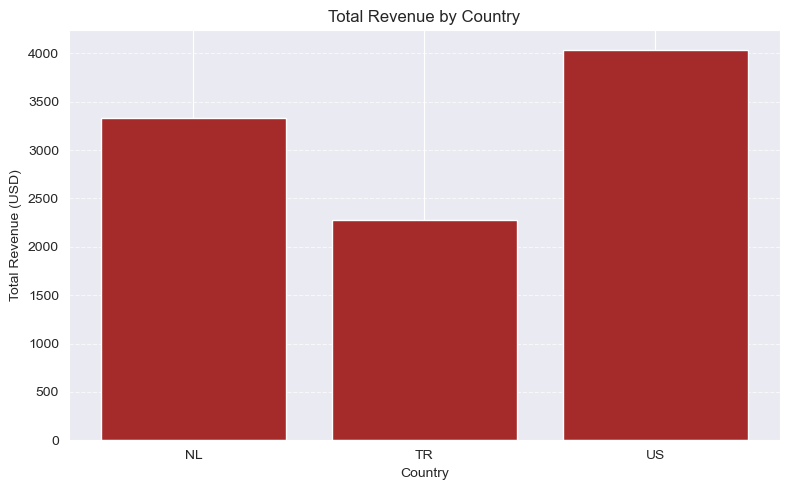

In [1224]:
plt.figure(figsize=(8, 5))
plt.bar(revenue_df['user_country'], revenue_df['amount_usd'], color='brown')
plt.title('Total Revenue by Country')
plt.xlabel('Country')
plt.ylabel('Total Revenue (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Visuals/TotalRevenueByCountry')

## 5.2. Total number of trials from Instagram

This task was pretty straightforward. I selected rows where event_name is trial_started and user_attribution_source is instagram, then used len() to get the number of rows in the resulting dataframe.
<br> In one line solution, i select both rows from  merged_df
<br> In more readable solution, i select trial_started = True from merged_df, and then select the instagram from the resulting dataframe. then print out the length of the resulting dataframe.

### one line solution

In [1229]:
len(merged_df[(merged_df['event_name']=='trial_started') & (merged_df['user_attribution_source']=='instagram')])

210

### more readable solution

In [1232]:
trial_started_data = merged_df[merged_df['event_name']=='trial_started']
trial_started_from_instagram_data = trial_started_data[trial_started_data['user_attribution_source']=='instagram']
print(f'Total of {len(trial_started_from_instagram_data)} users have started their trials from instagram.')

Total of 210 users have started their trials from instagram.


## 5.3. New column acquisition_channel

I checked the unique values in **user_attribution_source** and saw that there are no options other than the ones mentioned in the task. Organic means organic, and the other two options are paid. I used a lambda function with an if-else statement that returns organic if the value is organic, and paid if it’s something else (which would be either instagram or tiktok).

In [1236]:
merged_df['user_attribution_source'].unique()

array(['instagram', 'tiktok', 'organic'], dtype=object)

In [1238]:
merged_df['acquisition_channel'] = merged_df['user_attribution_source'].apply(lambda x: 'Organic' if x=='organic' else 'Paid')

In [1240]:
merged_df[['user_attribution_source', 'acquisition_channel']].sample(5)

,user_attribution_source,acquisition_channel
1280,tiktok,Paid
2429,tiktok,Paid
845,organic,Organic
1056,tiktok,Paid
1431,instagram,Paid


## 5.4. Trial-to-Subscription Conversion Rate

### 5.4.1. Overall conversion rate

First I grouped the dataset with **user_id** to choose each id individually, then select **event_name** column and applied list over it. This way, now there is a list for each user with all of **event_type**'s user has done. Then, I select users with **trial_started** in their lists, which means they started a trial. Following that, I only chose the users which has *subscription_started* from the list of users where *trial_started* was included. TO sum up, I chose users which has both *trial_starte* and *subscription_started* in their event_name list. Finally, I calculated the conversion rate by dividing the number of converted users by the total number of trial users and printed the result using formatted output for better readability.

In [1245]:
user_events = merged_df.groupby('user_id')['event_name'].apply(list)
trial_users = user_events[user_events.apply(lambda x: 'trial_started' in x)]
converted_users = trial_users[trial_users.apply(lambda x: 'subscription_started' in x)]
overall_conversion_rate = len(converted_users) / len(trial_users) * 100
print(f"Overall Trial-to-Subscription Conversion Rate: {overall_conversion_rate:.2f}%")

Overall Trial-to-Subscription Conversion Rate: 70.53%


### 5.4.2. Breakdown of conversion by attribution_source

First, I dropped the duplicates from the dataset to get one row per user and kept their **user_id** and **user_attribution_source**, then set **user_id** as the index. After that, I created a new dataframe where each user had a list of all the events they triggered. Then, I selected the users who had *trial_started* in their event list, meaning they started a trial. From that list, I checked which users also had *subscription_started*, and marked them as converted. Finally, I grouped the dataframe by **user_attribution_source** and took the mean of the *converted* column, then multiplied by 100 to get the conversion rate for each source.

In [1249]:
user_info = merged_df.drop_duplicates('user_id')[['user_id', 'user_attribution_source']].set_index('user_id')
user_events_df = pd.DataFrame({'event_list': user_events}).join(user_info)
trial_df = user_events_df[user_events_df['event_list'].apply(lambda x: 'trial_started' in x)].copy()
trial_df['converted'] = trial_df['event_list'].apply(lambda x: 'subscription_started' in x)
conversion_by_source = trial_df.groupby('user_attribution_source')['converted'].mean() * 100

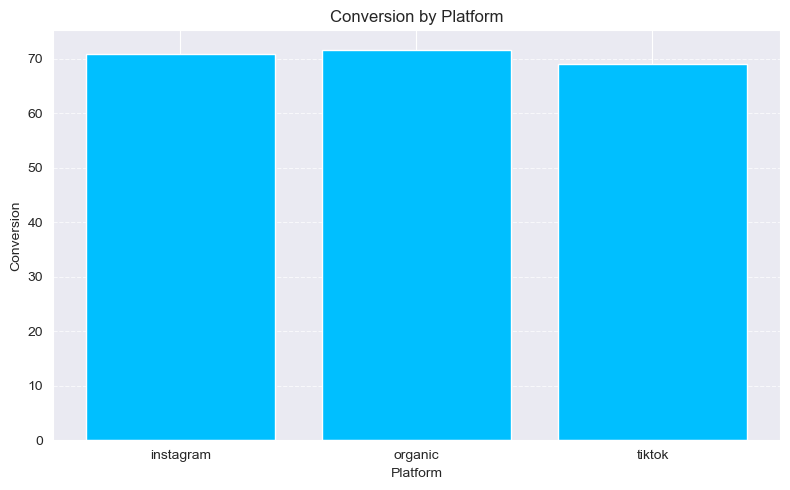

In [1251]:
conversion_by_source_df = pd.DataFrame(conversion_by_source).reset_index()
plt.figure(figsize=(8, 5))
plt.bar(conversion_by_source_df['user_attribution_source'], conversion_by_source_df['converted'], color='deepskyblue')
plt.title('Conversion by Platform')
plt.xlabel('Platform')
plt.ylabel('Conversion')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Visuals/ConversionRateByPlatform')

## 5.5. Median Subscription Duration in Each Country

For this task, I calculated the subscription duration for each user by using the time between their *subscription_started* and *subscription_cancelled* events. I first filtered the dataset to include only those two events, then pivoted the table to get both timestamps for each user. If a user didn’t have a *subscription_cancelled* event, I assumed they are still subscribed and filled the missing value with today’s date. After that, I calculated the duration in days and divided by 30 to estimate the duration in months. <br>Finally, I added the **user_country** column and grouped the data by country to calculate the median subscription duration for each one.

In [1255]:
subs_df = merged_df[merged_df['event_name'].isin(['subscription_started', 'subscription_cancelled'])].copy()
subs_df['created_at'] = pd.to_datetime(subs_df['created_at'])

In [1257]:
pivot_df = subs_df.pivot_table(index='user_id', columns='event_name', values='created_at', aggfunc='min')
pivot_df['subscription_cancelled'] = pivot_df['subscription_cancelled'].fillna(datetime.today())
pivot_df['subscription_cancelled'] = pivot_df['subscription_cancelled'].dt.normalize()
pivot_df['duration_days'] = (pivot_df['subscription_cancelled'] - pivot_df['subscription_started']).dt.days
pivot_df['duration_months'] = pivot_df['duration_days'] / 30

In [1259]:
country_df = merged_df[['user_id', 'user_country']].drop_duplicates('user_id').set_index('user_id')
pivot_df = pivot_df.join(country_df)

In [1261]:
median_duration_all = pivot_df.groupby('user_country')['duration_months'].median().round(2)
print(median_duration_all)

user_country
NL    2.77
TR    2.87
US    2.57
Name: duration_months, dtype: float64


Index(['user_country', 'duration_months'], dtype='object')


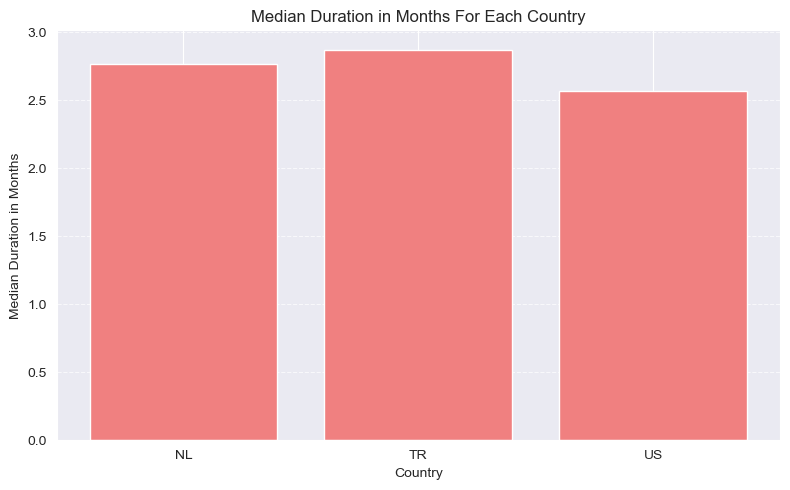

In [1263]:
median_duration_all_df = median_duration_all.reset_index()
print(median_duration_all_df.columns)
plt.figure(figsize=(8, 5))
plt.bar(median_duration_all_df['user_country'], median_duration_all_df['duration_months'], color='lightcoral')
plt.title('Median Duration in Months For Each Country')
plt.xlabel('Country')
plt.ylabel('Median Duration in Months')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Visuals/MedianDurationMonthsCountry')

## 5.6. LTV - Lifetime Value For Each Country

In [1266]:
ltv_df = merged_df.groupby('user_id')['amount_usd'].sum().reset_index()
user_info = merged_df[['user_id', 'user_country']].drop_duplicates('user_id')
ltv_df = ltv_df.merge(user_info, on='user_id')

In [1268]:
ltv_df.groupby('user_country')['amount_usd'].mean()

user_country
NL    10.828864
TR     6.427797
US    11.870471
Name: amount_usd, dtype: float64

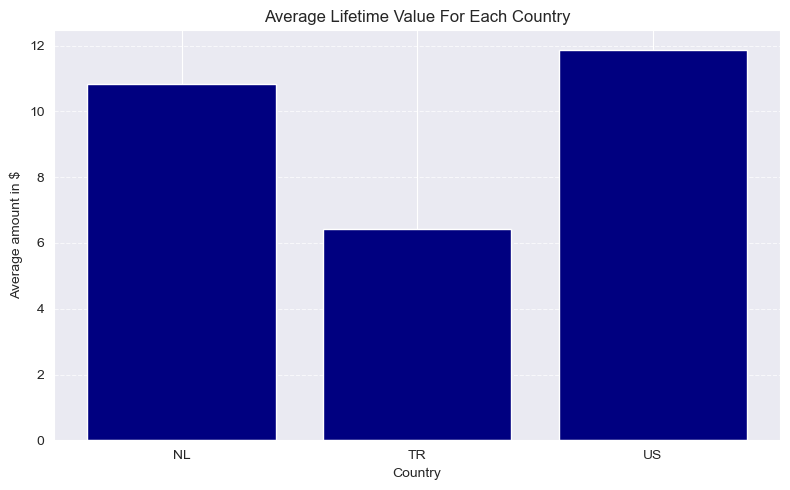

In [1270]:
ltv_graph_df = ltv_df.groupby('user_country')['amount_usd'].mean().reset_index()
plt.figure(figsize=(8, 5))
plt.bar(ltv_graph_df['user_country'], ltv_graph_df['amount_usd'], color='navy')
plt.title('Average Lifetime Value For Each Country')
plt.xlabel('Country')
plt.ylabel('Average amount in $')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Visuals/AverageLtvCountry')

## 5.7. Explanation of Graphs

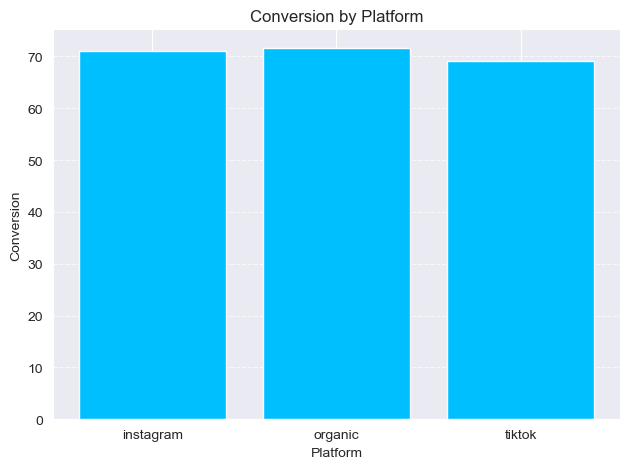

In [1273]:
plt.bar(conversion_by_source_df['user_attribution_source'], conversion_by_source_df['converted'], color='deepskyblue')
plt.title('Conversion by Platform')
plt.xlabel('Platform')
plt.ylabel('Conversion')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Visuals/ConversionRateByPlatform')

Since all of them work with the same logic, I wanted to explain what I did in one paragraph for all. <br>First, I converted the final result into a DataFrame. Except for the graph in section 5.1, I did this conversion inside the graph block itself. In the first one, I handled it during the final printing step, so both result and graph generation approaches could be demonstrated. <br>Then, I set the figure size to 8x5 for a larger and clearer graph. <br>After that, I created a bar plot using Matplotlib, passing objects (such as country or attribution) to the x axis and the numerical values expected by the task to the y axis. I set the axis labels and graph title according to each task. <br>Following that, I added a grid to make the results more readable. I also used tight_layout() for cleaner and more balanced appearance. <br>Finally, I saved each graph with a task-specific name inside the Visuals folder, which was created at the beginning of the notebook.

# 6. Bonus Tasks

## 6.1. Churn Probability of Clark Kent

In this task, I tried to add as many features as I could while avoiding data leakage.<br>
In terms of task's success, the prediction of Clark Kent was completed correctly. Each model predicted Clark Kent accurately.<br>
In general, the models’ accuracies were between 59% and 70%.<br>

Let me explain what I did:<br>
First, I created a user_events dataframe, which includes “user_id” (the ID of the user) and a list of events that each user has done. From this list, I labeled users who had “subscription_canceled” as churned, and users who had “trial_started” as trial users.Many deep analyses could be done here (like comparing churn rates for trial users), but I wanted to keep things simple and focused.<br>

Then, I created the churned dataframe (the model dataframe) by copying the users dataframe. I mapped the churned and trial_started columns from user_events to this new dataframe.<br>

Next, I created a loop over feature names to generate group-based aggregations like mean and sum. I grouped churned_df by each feature (like country or attribute), then calculated those aggregations. I used two variables and two lines for readability, but this could be done in one line. I also calculated churn_ratio. Inside the loop, I added another loop to map each aggregated value to the original dataframe using the base column (e.g., country or attribute).I also tried one-hot encoding, but it didn’t help the models much, so I commented it out and decided not to use it.<br>

After that, I dropped the columns that were object-type or not related to the model (like user ID).Then, I separated the Clark Kent row from the dataframe to prevent data leakage for the final task.<br>

Then, I split the data into X (features) and y (target), and scaled both X and Clark Kent’s data. Then, I split X and y into training and test sets.<br>

Next, I created a model dictionary with model names as keys and model objects as values. I looped over this dictionary, fitted each model, and made predictions on X_test. To make the accuracy more readable, I multiplied the score by 100 (since it is between 0 and 1 by default).I also printed the F1 score in each iteration to check for overfitting. During each iteration, I let the models predict Clark Kent using his scaled data and all models predicted correctly.<br>

Finally, I created a correlation heatmap based on churned_df, and a bar plot showing model accuracies.<br>

I also ran many tests (which I later deleted) to check for overfitting and to improve the accuracy.I was not sure if using the “trial user” column was a data leak, but I assumed it’s fine because it didn’t seem too directly related to churn.When I used the number of events per user in the model, it predicted with 100% accuracy — but I believe that is data leakage.
I added a photo below showing the result I mentioned.

<img src='accuracy100_usingevent.png'></img>

### 6.1.1. Churned Dataframe Creation

In [1281]:
user_events = merged_df.groupby('user_id')['event_name'].apply(list).reset_index()

In [1283]:
user_events['churned'] = user_events['event_name'].apply(lambda x: 1 if 'subscription_cancelled' in x else 0)
user_events['trial_started'] = user_events['event_name'].apply(lambda x: 1 if 'trial_started' in x else 0)

In [1285]:
churned_df = users_df.copy()
churned_df['churned'] = churned_df.index.map(user_events['churned'])
churned_df['trial_started'] = churned_df.index.map(user_events['trial_started'])

### 6.1.2. Adding Feature aggreagations based on country and user attribute

In [1288]:
for ftr in ['user_attribution_source', 'user_country']:
    future_grouped = churned_df.groupby(ftr)
    future_agg = future_grouped['churned'].agg(['mean','sum'])
    future_agg['churn_ratio'] = future_agg['sum'] / len(churned_df)
    for col in future_agg.columns:
        churned_df[f"{ftr}_{col}"] = churned_df[ftr].map(future_agg[col])

In [1290]:
#churned_df = pd.get_dummies(churned_df,columns=['user_attribution_source','user_country'],drop_first=True)

### 6.1.3. Seperating Clark Kent and Dropping model-unrelated Columns

In [1293]:
churned_df = churned_df.drop(['user_id','user_created_at', 'user_name','user_country','user_attribution_source'], axis=1)
clark_kent = churned_df.iloc[[1001]]
churned_df = churned_df.drop(1001)

### 6.1.4.Splitting and Scaling

In [1296]:
X = churned_df.drop('churned', axis=1)
y = churned_df['churned']

churn_scaler = StandardScaler()
X = churn_scaler.fit_transform(X)
clark_kent_scaled = churn_scaler.transform(clark_kent.drop('churned',axis=1))
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=34)

### 6.1.5.Classifier Model Dictionary

In [1299]:
params = {
    'n_estimators': 1000,
    'learning_rate': 0.07,
    'gamma': 0.9,
}

clf_model_dict = {'LogisticRegression': LogisticRegression(),
                 'DecisionTreeClassifier': DecisionTreeClassifier(),
                  'RandomForestClassifier':RandomForestClassifier(n_estimators=750),
                 'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=3),
                 'XGBoost':XGBClassifier(**params)}

### 6.1.6. Fit & Prediction Phase

In [1302]:
accuracy_list = []
for clf_model_name in clf_model_dict:
    clf_model = clf_model_dict[clf_model_name]
    clf_model.fit(X_train, y_train)
    clf_pred = clf_model.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, clf_pred)*100)
    print(f"Accuracy of {clf_model_name}: %{accuracy_score(y_test, clf_pred)*100:.2f}\n\
F1-Score of {clf_model_name}: {f1_score(y_test, clf_pred):.2f}\n\
Clark Kent Prediction: {clf_model.predict(clark_kent_scaled)[0]} \nActual Clark Kent: {clark_kent['churned'].iloc[0]}\n")

Accuracy of LogisticRegression: %61.69
F1-Score of LogisticRegression: 0.58
Clark Kent Prediction: 0 
Actual Clark Kent: 0

Accuracy of DecisionTreeClassifier: %60.20
F1-Score of DecisionTreeClassifier: 0.59
Clark Kent Prediction: 0 
Actual Clark Kent: 0

Accuracy of RandomForestClassifier: %60.20
F1-Score of RandomForestClassifier: 0.59
Clark Kent Prediction: 0 
Actual Clark Kent: 0

Accuracy of KNeighborsClassifier: %69.65
F1-Score of KNeighborsClassifier: 0.68
Clark Kent Prediction: 0 
Actual Clark Kent: 0

Accuracy of XGBoost: %69.65
F1-Score of XGBoost: 0.74
Clark Kent Prediction: 0 
Actual Clark Kent: 0



### 6.1.7. Correlation & Accuracy Graph

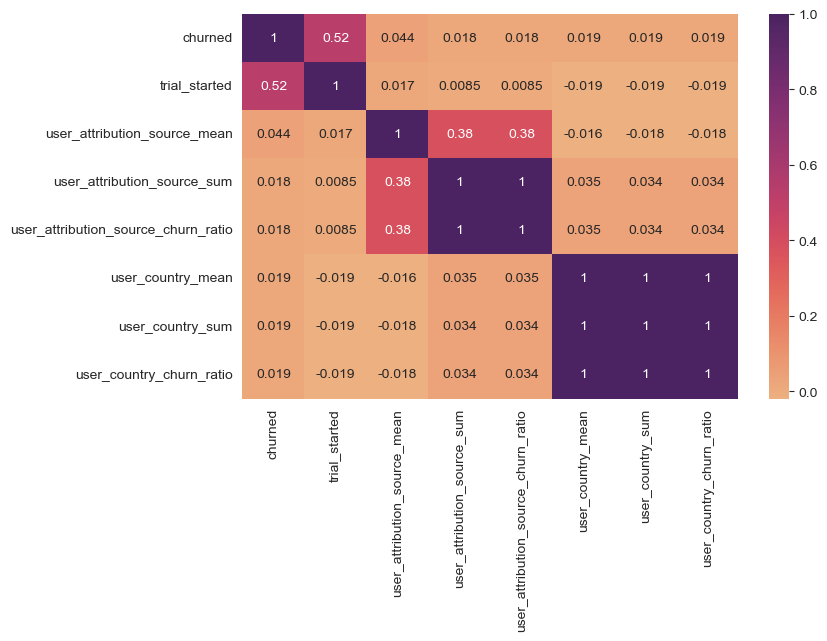

In [1304]:
plt.figure(figsize=(8,5))
sns.heatmap(churned_df.corr(),cmap='flare',annot=True)
plt.savefig('Visuals/ChurnedDFCorrelationHeatmap')

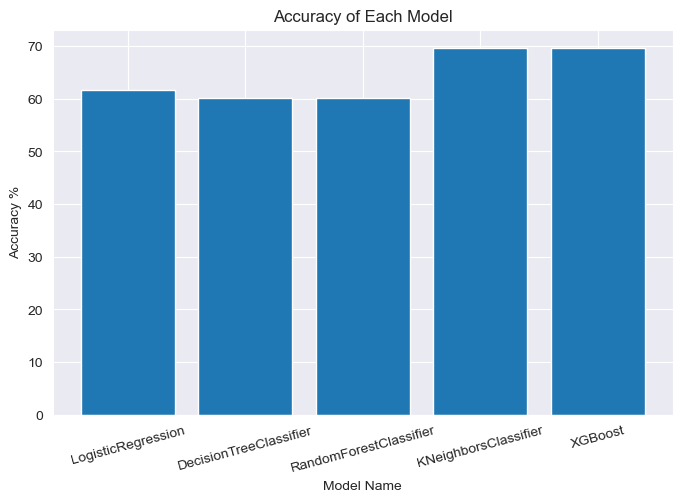

In [1305]:
plt.figure(figsize=(8,5))
plt.bar(clf_model_dict.keys() ,accuracy_list)
plt.xticks(rotation=15)
plt.xlabel('Model Name')
plt.ylabel('Accuracy %')
plt.title('Accuracy of Each Model')
plt.savefig('Visuals/ClassifierModelAccuracies')

## 6.2. Potential Lifetime Value Prediction of Bruce Wayne

In this model, I tried to add as many features as I could while avoiding data leakage at the same time. I experimented with many columns and different models, aggregating the user events dataframe to extract features. However, many features felt like data leakage. Features such as the count of events per user, or their subscription start, cancel, and renewal dates all seemed like data leakage, so I did not use them. When I included them, the MAE was lower than 2 and Bruce Wayne’s prediction was between 9–12.<br>

Coming back to the final work, let me explain what I did:<br> First, I created a model dataframe, which is a copy of the users dataframe. Then, I retrieved the lifetime value data from the previous task's dataframe. I mapped it using user_ids and added the lifetime values to the model dataframe.<br>

Next, I aggregated based on countries. I calculated the mean and sum of LTVs per country, and also counted the number of events for each country, for each event.<br>

After that, I did the same with user_attribution_source.<br>

Following that, I one-hot encoded the countries and attribution sources using pd.get_dummies().<br>

Then, I added a somewhat risky column called "trial_started", which checks whether a user had a trial phase on the app. It doesn't have a high correlation like the above examples of subscription (those had correlations of 0.95+), and the event count column had a correlation of 1.<br>

After that, I split the dataframe into X and y, but first removed Bruce Wayne from the dataset to avoid leakage in the final prediction task.<br>

Then, I created a model dictionary that includes model names as keys and models as values, allowing me to loop over them and make predictions with less code. I fit and tested the models using the mean absolute error (MAE) metric. I also predicted Bruce Wayne’s value and displayed it.<br>

Finally, I printed the correlations of the columns,this ideally should have been done earlier, but I included it at the end. Then, I created a scatter plot for each prediction made by each model which is  stored in predictions_list.<br>

### 6.2.1 Model DataFrame Creation

In [1309]:
ltv_model_df = users_df.copy()

In [1311]:
ltv_df.index = ltv_df.user_id
ltv_model_df['ltv'] = ltv_model_df['user_id'].map(ltv_df['amount_usd'])

### 6.2.2. Aggregation results based on country

In [1313]:
ltv_df_grouped_country = ltv_df.groupby('user_country')['amount_usd'].agg(['mean','sum']) ## all medians were the same so i didn't included median
for col in ltv_df_grouped_country:
    ltv_model_df[f"country_ltv_{col}"] = ltv_model_df['user_country'].map(ltv_df_grouped_country[col])

In [1314]:
country_event_counts = pd.DataFrame(merged_df.groupby('user_country')['event_name'].value_counts())
country_event_counts = country_event_counts.reset_index().pivot(index='user_country', columns='event_name', values='count')
for col in country_event_counts.columns:
    ltv_model_df[f"country_{col}_count"] = ltv_model_df['user_country'].map(country_event_counts[col])

### 6.2.3. Aggregation results based on attribute

In [1317]:
ltv_df_grouped_attribution = ltv_model_df.groupby('user_attribution_source')['ltv'].agg(['mean', 'sum'])
for col in ltv_df_grouped_attribution:
    ltv_model_df[f"attribute_ltv_{col}"] = ltv_model_df['user_attribution_source'].map(ltv_df_grouped_attribution[col])

In [1319]:
attribute_event_counts = pd.DataFrame(merged_df.groupby('user_attribution_source')['event_name'].value_counts())
attribute_event_counts = attribute_event_counts.reset_index().pivot(index='user_attribution_source', columns='event_name', values='count')
for col in attribute_event_counts.columns:
    ltv_model_df[f"attribute_{col}_count"] = ltv_model_df['user_attribution_source'].map(attribute_event_counts[col])

### 6.2.4. Labeling class columns (country and attribute)

In [1327]:
ltv_model_df = pd.get_dummies(ltv_model_df, columns=['user_attribution_source', 'user_country'], drop_first=True)

### 6.2.5.Risky columns that can leak

In [1330]:
user_events = events_df.groupby('user_id')['event_name'].apply(list)
ltv_model_df['trial_started'] = ltv_model_df['user_id'].apply(lambda u: 1 if 'trial_started' in user_events[u] else 0) 

### 6.2.6. Splitting: X, y and Bruce Wayne Data

In [1333]:
ltv_model_df = ltv_model_df.drop(['user_id','user_created_at','user_name'], axis=1)

In [1335]:
bruce_wayne = bruce_df = ltv_model_df.loc[[1000]].drop(columns='ltv') # this is index and not user ID so user_id-1
ltv_model_df = ltv_model_df.drop(1000)

In [1337]:
X = ltv_model_df.drop('ltv', axis=1)
y = ltv_model_df['ltv']

scaler = StandardScaler()
X = scaler.fit_transform(X)
bruce_wayne = scaler.fit_transform(bruce_wayne)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=26)

### 6.2.7. Fit and Prediction

In [1340]:
model_dict = {'LinearRegression':LinearRegression(),
             'Lasso':Lasso(alpha=0.75),
             'Ridge':Ridge(alpha=0.5),
             'DecisionTreeRegressor':DecisionTreeRegressor(random_state=26),
             'RandomForestRegressor':RandomForestRegressor(n_estimators = 600, max_depth=8, random_state=26),
             'KNeighborsRegressor':KNeighborsRegressor(n_neighbors=2),
             'XGBoost': XGBRegressor(n_estimators=750,learning_rate=0.1, max_depth=8)}

In [1342]:
prediction_list = []
for model_name in model_dict: 
    model = model_dict[model_name]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"{model_name}\nMAE: {mean_absolute_error(y_test, pred)}")
    print(f"Bruce Wayne Predicted: {model.predict(bruce_wayne)[0]}\
      \nBruce Wayne Actual:    {9.99}\n")
    prediction_list.append(pred)

LinearRegression
MAE: 8.117311367436221
Bruce Wayne Predicted: 9.85339859392997      
Bruce Wayne Actual:    9.99

Lasso
MAE: 7.978042367656916
Bruce Wayne Predicted: 9.54134903631052      
Bruce Wayne Actual:    9.99

Ridge
MAE: 8.058364278535754
Bruce Wayne Predicted: 9.56068270226394      
Bruce Wayne Actual:    9.99

DecisionTreeRegressor
MAE: 7.316330478190631
Bruce Wayne Predicted: 16.321690140845078      
Bruce Wayne Actual:    9.99

RandomForestRegressor
MAE: 7.312915125505941
Bruce Wayne Predicted: 15.413156484679096      
Bruce Wayne Actual:    9.99

KNeighborsRegressor
MAE: 9.070074626865672
Bruce Wayne Predicted: 0.0      
Bruce Wayne Actual:    9.99

XGBoost
MAE: 7.316339411795493
Bruce Wayne Predicted: 5.00325950270053e-05      
Bruce Wayne Actual:    9.99



### 6.2.8. Correlations

In [1344]:
ltv_model_df.corr()['ltv'].sort_values(ascending=False)

ltv                                       1.000000
trial_started                             0.522927
country_ltv_mean                          0.190456
country_ltv_sum                           0.186060
user_country_US                           0.127525
attribute_ltv_mean                        0.040532
country_trial_cancelled_count             0.038650
user_attribution_source_organic           0.029477
attribute_subscription_renewed_count      0.028838
attribute_subscription_cancelled_count    0.025595
attribute_ltv_sum                         0.020017
attribute_subscription_started_count      0.002149
attribute_trial_started_count            -0.010301
attribute_app_install_count              -0.016809
attribute_trial_cancelled_count          -0.029033
user_attribution_source_tiktok           -0.039248
country_app_install_count                -0.115502
country_trial_started_count              -0.120414
country_subscription_cancelled_count     -0.120414
country_subscription_started_co

### 6.2.9. Prediction Graphs

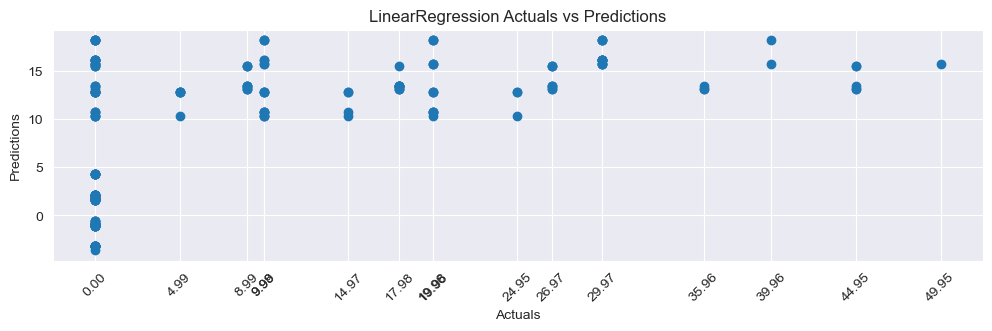

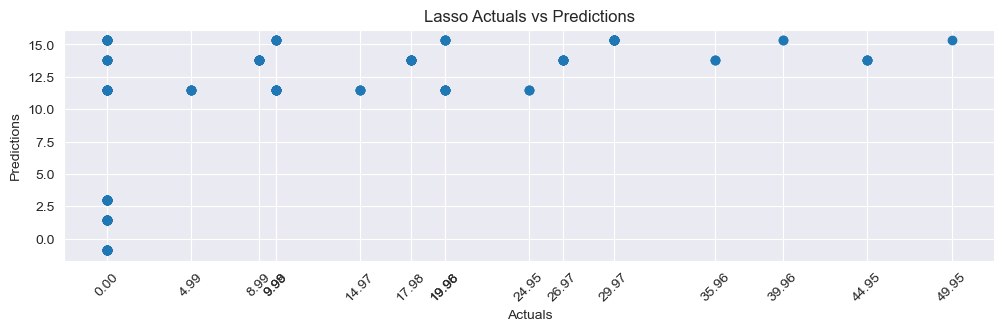

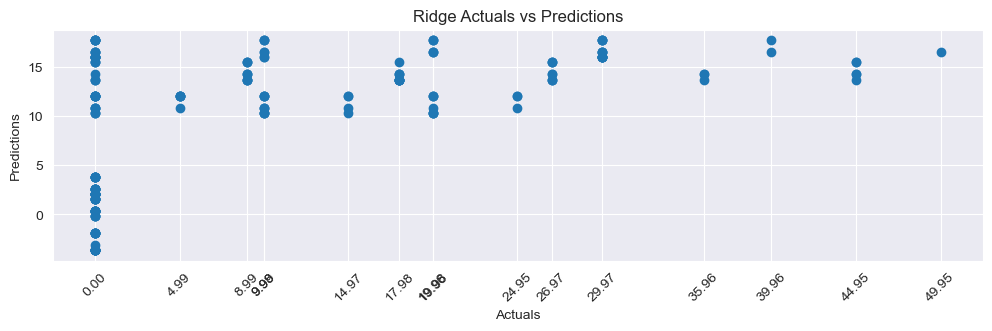

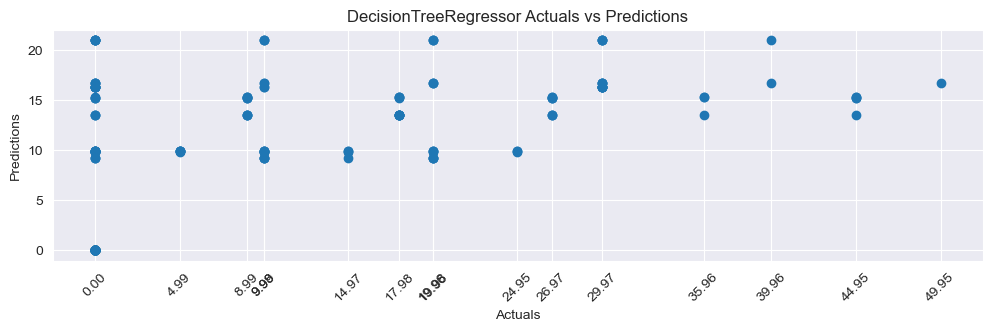

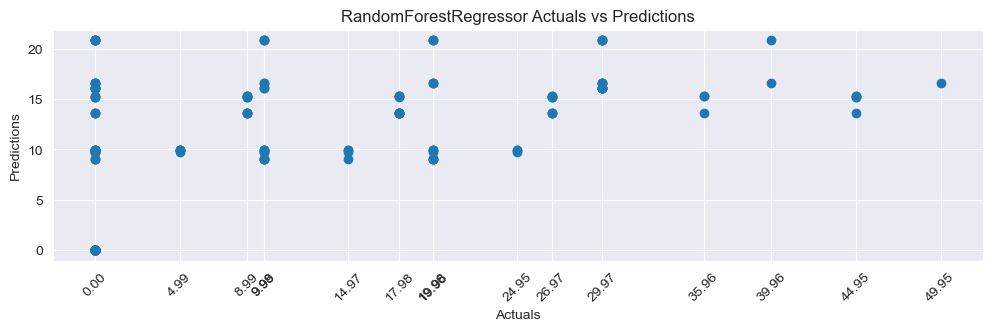

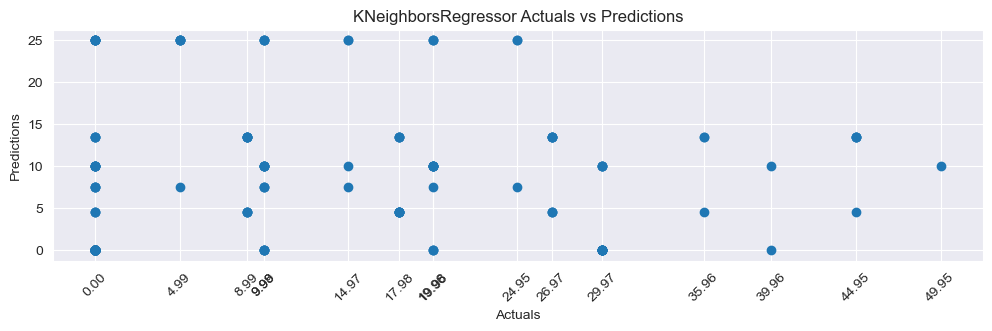

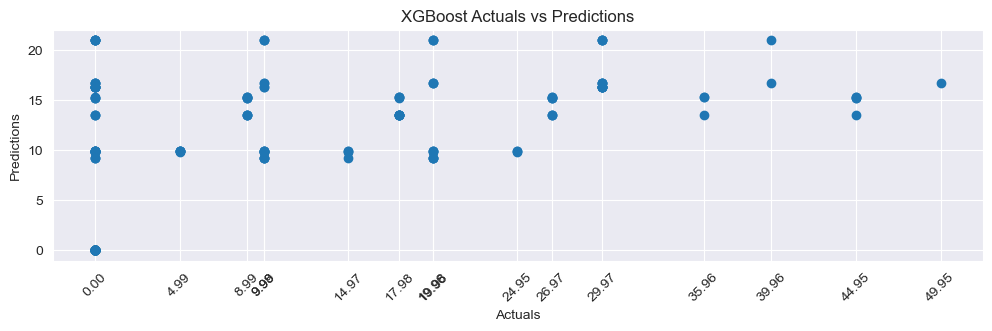

In [1346]:
for idx,l in enumerate(prediction_list):
    plt.figure(figsize=(12,3))
    plt.scatter(y_test, l)
    plt.title(f"{list(model_dict.keys())[idx]} Actuals vs Predictions")
    plt.xlabel('Actuals')
    plt.xticks(np.unique(y_test), rotation=45)
    plt.ylabel('Predictions')
    plt.savefig(f"Visuals/{list(model_dict.keys())[idx]}_PredGraph")
    plt.show()